In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
df_raw = pd.read_csv('../spark/mllib/Sacramentorealestatetransactions.csv', parse_dates=['sale_date'], header=0)
df_raw.rename(columns = {'sq__ft':'sqft'}, inplace = True)
df_raw.head()

,street,city,zip,state,beds,baths,sqft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,2008-05-21 04:00:00,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,2008-05-21 04:00:00,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,2008-05-21 04:00:00,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,2008-05-21 04:00:00,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,2008-05-21 04:00:00,81900,38.519470,-121.435768


In [3]:
df = df_raw.drop(['street', 'state', 'city', 'sale_date', 'zip', 'latitude', 'longitude'], axis=1)

In [4]:
df.head()

,beds,baths,sqft,type,price
0,2,1,836,Residential,59222
1,3,1,1167,Residential,68212
2,2,1,796,Residential,68880
3,2,1,852,Residential,69307
4,2,1,797,Residential,81900


In [5]:
df.shape

(985, 5)

In [6]:
msk = (df_raw.sqft == 0) & (df_raw.beds == 0) & (df_raw.baths == 0)
df = df[~msk]

In [7]:
df.shape

(877, 5)

In [8]:
df['type'].value_counts()

Residential     818
Condo            46
Multi-Family     13
Name: type, dtype: int64

In [9]:
df = pd.get_dummies(df, columns=['type'])
df.rename(columns={'type_Condo':'condo'}, inplace = True)
df.rename(columns={'type_Multi-Family':'multi'}, inplace = True)
df.rename(columns={'type_Residential':'res'}, inplace = True)

In [10]:
df.head()

,beds,baths,sqft,price,condo,multi,res
0,2,1,836,59222,0,0,1
1,3,1,1167,68212,0,0,1
2,2,1,796,68880,0,0,1
3,2,1,852,69307,0,0,1
4,2,1,797,81900,0,0,1


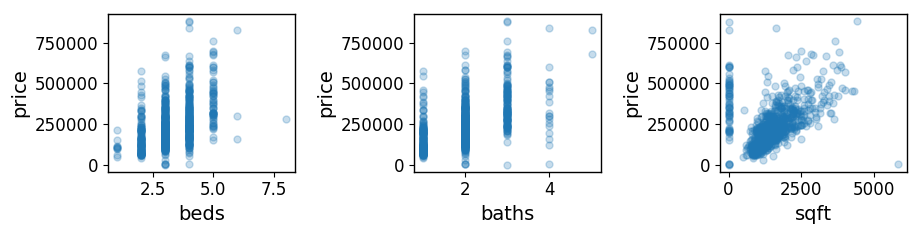

In [11]:
fig = plt.figure(figsize=(9.5, 2.5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(df.beds, df.price, alpha=0.25, s=25)
ax1.set_xlabel('beds')
ax1.set_ylabel('price')
ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(df.baths, df.price, alpha=0.25, s=25)
ax2.set_xlabel('baths')
ax2.set_ylabel('price')
ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(df.sqft, df.price, alpha=0.25, s=25)
ax3.set_xlabel('sqft')
ax3.set_ylabel('price')
plt.tight_layout()

In [12]:
df.corr()

,beds,baths,sqft,price,condo,multi,res
beds,1.000000,0.659514,0.497661,0.450966,-0.357664,0.169095,0.236736
baths,0.659514,1.000000,0.478494,0.524377,-0.186358,0.194976,0.071793
sqft,0.497661,0.478494,1.000000,0.361688,-0.180886,0.092031,0.116586
price,0.450966,0.524377,0.361688,1.000000,-0.182622,-0.014467,0.169508
condo,-0.357664,-0.186358,-0.180886,-0.182622,1.000000,-0.028860,-0.876050
multi,0.169095,0.194976,0.092031,-0.014467,-0.028860,1.000000,-0.456736
res,0.236736,0.071793,0.116586,0.169508,-0.876050,-0.456736,1.000000


In [13]:
X = df[['beds', 'baths', 'sqft', 'condo', 'multi', 'res']].copy()
y = df.price.copy()

In [14]:
X.head()

,beds,baths,sqft,condo,multi,res
0,2,1,836,0,0,1
1,3,1,1167,0,0,1
2,2,1,796,0,0,1
3,2,1,852,0,0,1
4,2,1,797,0,0,1


In [15]:
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()
X_std = std_sc.fit_transform(X[['beds', 'baths', 'sqft',]])

In [17]:
indicators = df[['condo', 'multi', 'res']].values
X_std = np.hstack((X_std, indicators))

In [18]:
X_std.shape

(877, 6)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [20]:
lr = LinearRegression()
lr.fit(X_std, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
r2_score(lr.predict(X_std), y), np.sqrt(mean_squared_error(lr.predict(X_std), y))

(-1.1243597089113844, 107270.59823643812)